In [2]:
import silence_tensorflow.auto
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from random import randint
from PIL import Image

In [3]:
train_dir = "Bird_525_Species/train/"
test_dir = "Bird_525_Species/test/"
valid_dir = "Bird_525_Species/valid/"

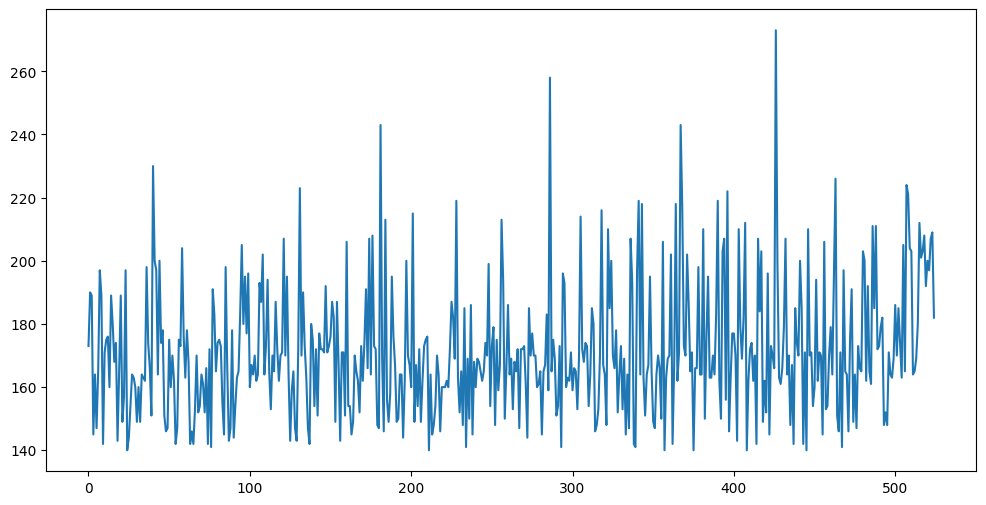

In [4]:
df = pd.read_csv("Bird_525_Species/birds.csv")
value_count = df['labels'].value_counts(sort=False)
x_axis = np.arange(len(value_count))
plt.figure(figsize=(12,6))
plt.plot(x_axis, value_count)
plt.show()

In [41]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

In [42]:
train_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42,
)
valid_images = valid_gen.flow_from_directory(
        directory=valid_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42,
)
test_images = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=42,
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

In [10]:
inputs = pretrained_model.input

layer1 = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
layer2 = tf.keras.layers.BatchNormalization()(layer1)
layer3 = tf.keras.layers.Dropout(0.4)(layer2)

layer4 = tf.keras.layers.Dense(512, activation='relu')(layer3)
layer5 = tf.keras.layers.BatchNormalization()(layer4)
layer6 = tf.keras.layers.Dropout(0.3)(layer5)

layer7 = tf.keras.layers.Dense(256, activation='relu')(layer6)
layer8 = tf.keras.layers.BatchNormalization()(layer7)
layer9 = tf.keras.layers.Dropout(0.2)(layer8)

outputs = tf.keras.layers.Dense(525, activation='softmax')(layer9)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,367,949 (16.66 MB)

 Trainable params: 2,106,381 (8.04 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

None


Epoch 1/200
 104/2645 ━━━━━━━━━━━━━━━━━━━━ 6:37 156ms/step - accuracy: 0.0254 - loss: 6.0913

I0000 00:00:1714156480.854075   18426 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2914', 540 bytes spill stores, 540 bytes spill loads

I0000 00:00:1714156481.089079   18413 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2914', 544 bytes spill stores, 544 bytes spill loads

I0000 00:00:1714156481.089420   18424 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2905', 204 bytes spill stores, 204 bytes spill loads



2645/2645 ━━━━━━━━━━━━━━━━━━━━ 428s 161ms/step - accuracy: 0.3081 - loss: 3.3733 - val_accuracy: 0.7337 - val_loss: 0.9434
Epoch 2/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 390s 147ms/step - accuracy: 0.6125 - loss: 1.4872 - val_accuracy: 0.7912 - val_loss: 0.7052
Epoch 3/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 389s 147ms/step - accuracy: 0.6620 - loss: 1.2671 - val_accuracy: 0.7985 - val_loss: 0.6937
Epoch 4/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 389s 147ms/step - accuracy: 0.6852 - loss: 1.1722 - val_accuracy: 0.8141 - val_loss: 0.6500
Epoch 5/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 389s 147ms/step - accuracy: 0.7025 - loss: 1.1107 - val_accuracy: 0.8286 - val_loss: 0.6032
Epoch 6/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 387s 146ms/step - accuracy: 0.7121 - loss: 1.0539 - val_accuracy: 0.8400 - val_loss: 0.5799
Epoch 7/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 388s 146ms/step - accuracy: 0.7197 - loss: 1.0262 - val_accuracy: 0.8453 - val_loss: 0.5287
Epoch 8/200
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 387s 146ms/step - accura

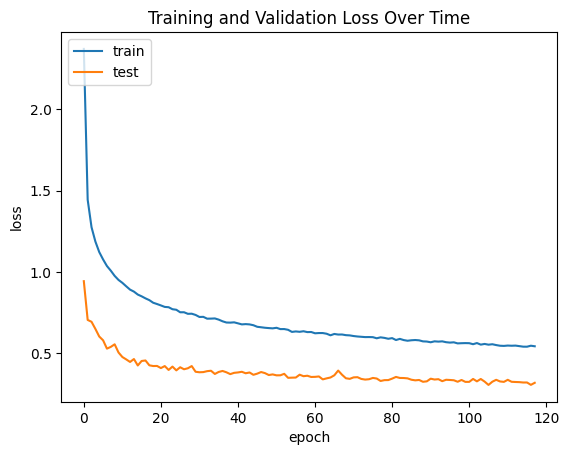

In [12]:
history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training and Validation Loss Over Time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save('Bird_model.keras')

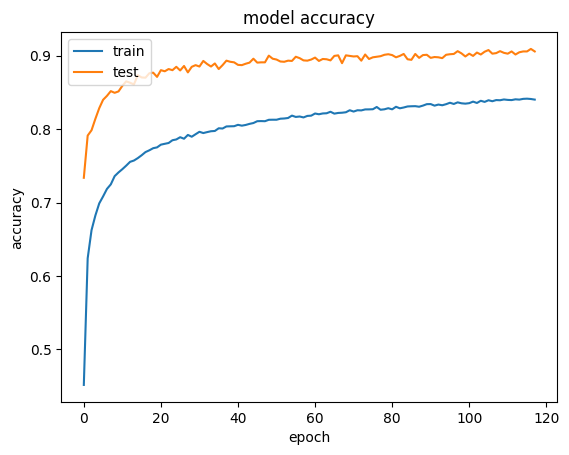

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
model = load_model('Bird_model.keras')

/home/aman/.conda/envs/NLP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 342 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [57]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

/home/aman/.conda/envs/NLP/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
Test Accuracy: 92.838%


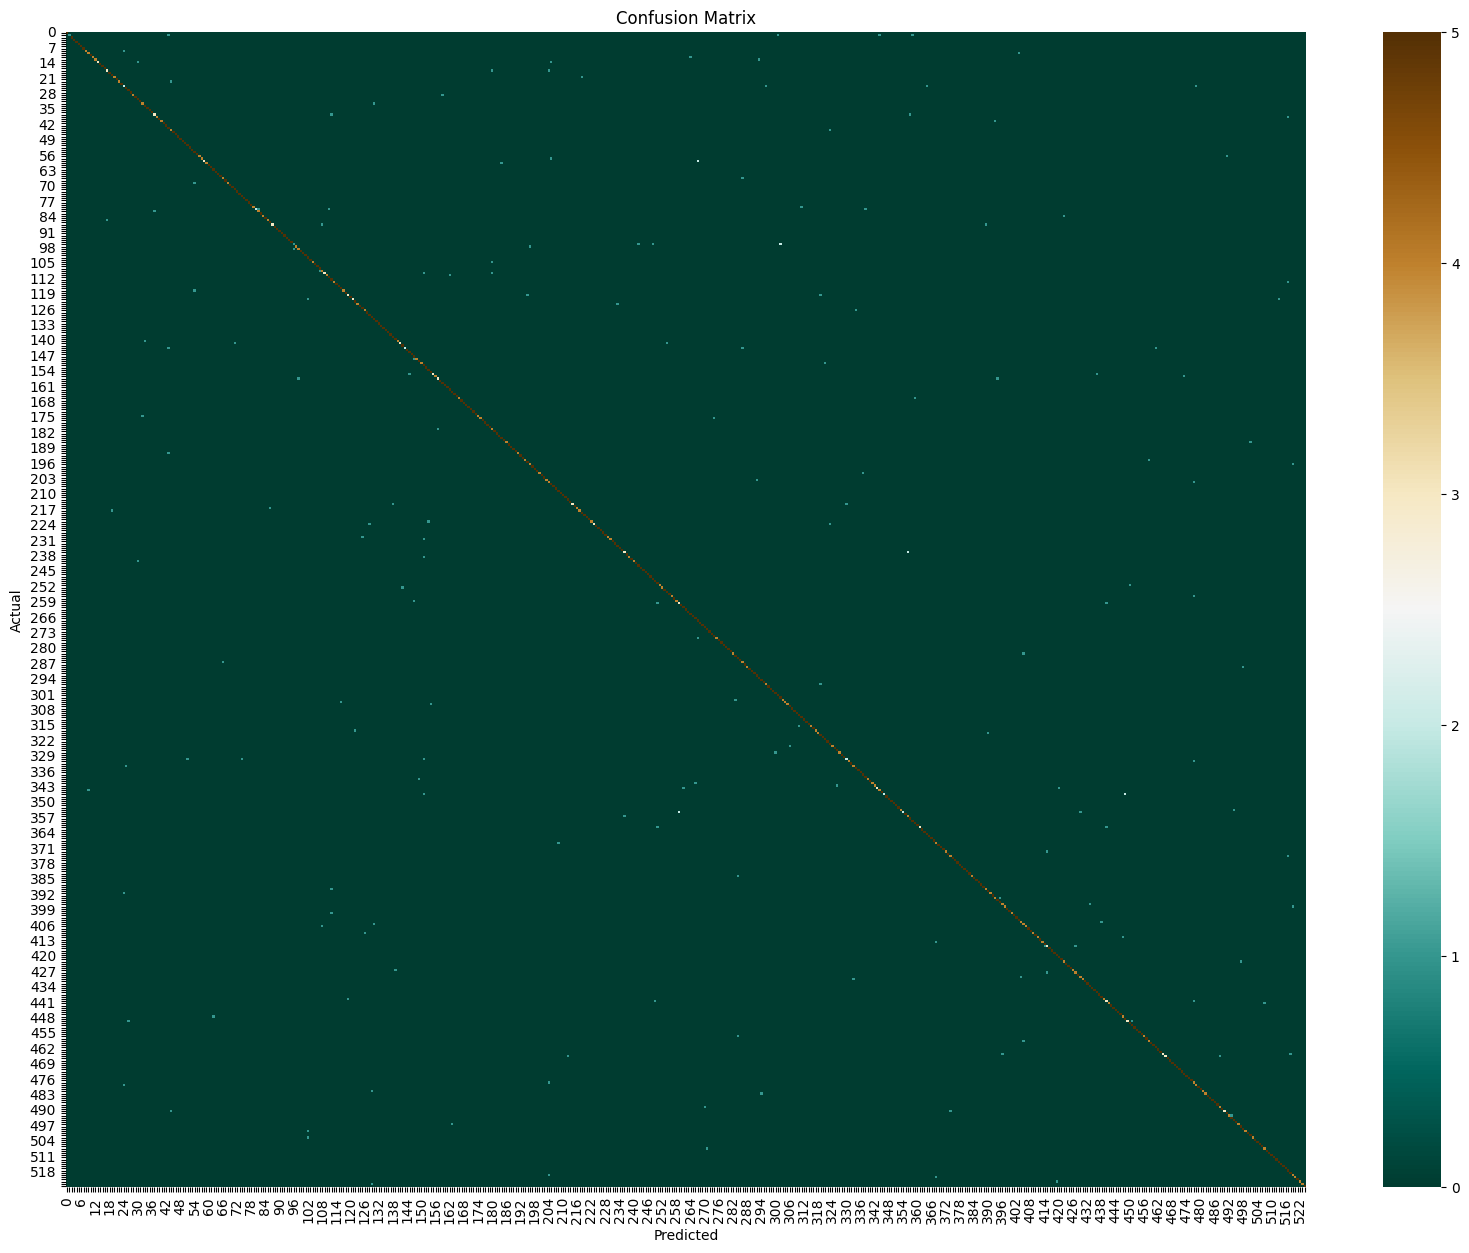

In [58]:
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, vmin=0, cmap='BrBG_r', cbar=True)
plt.xticks(ticks= np.arange(525) + 0.5,)
plt.yticks(ticks= np.arange(525) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


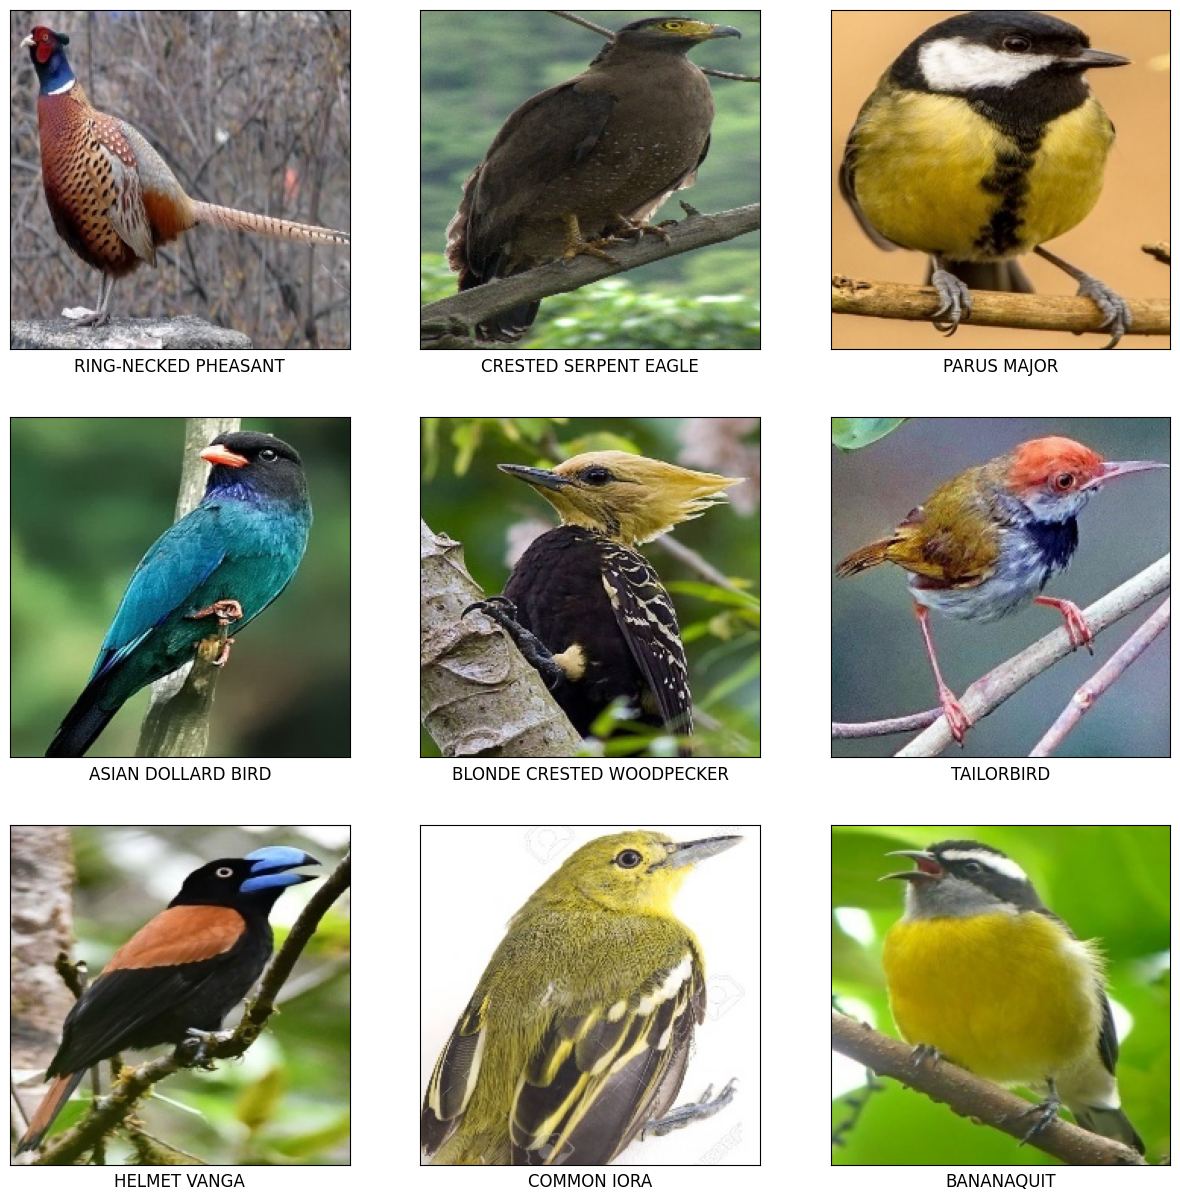

In [59]:
figure, axis = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        rand1 = randint(0,81)
        rand2 = randint(0,31)
        
        test_image = test_images[rand1][0][rand2] / 2 + 0.5
        axis[i,j].imshow(test_image)
        
        pred = np.argmax(model.predict(test_images[rand1][0]),axis=1)
        axis[i,j].set_title(CLASS_NAMES[pred[rand2]], y=-0.09)
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])

In [64]:
custom_test_dir="Bird_525_Species/custom_test/"
custom_test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)
custom_test_images = custom_test_gen.flow_from_directory(
        directory=custom_test_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=42,
)

Found 9 images belonging to 1 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


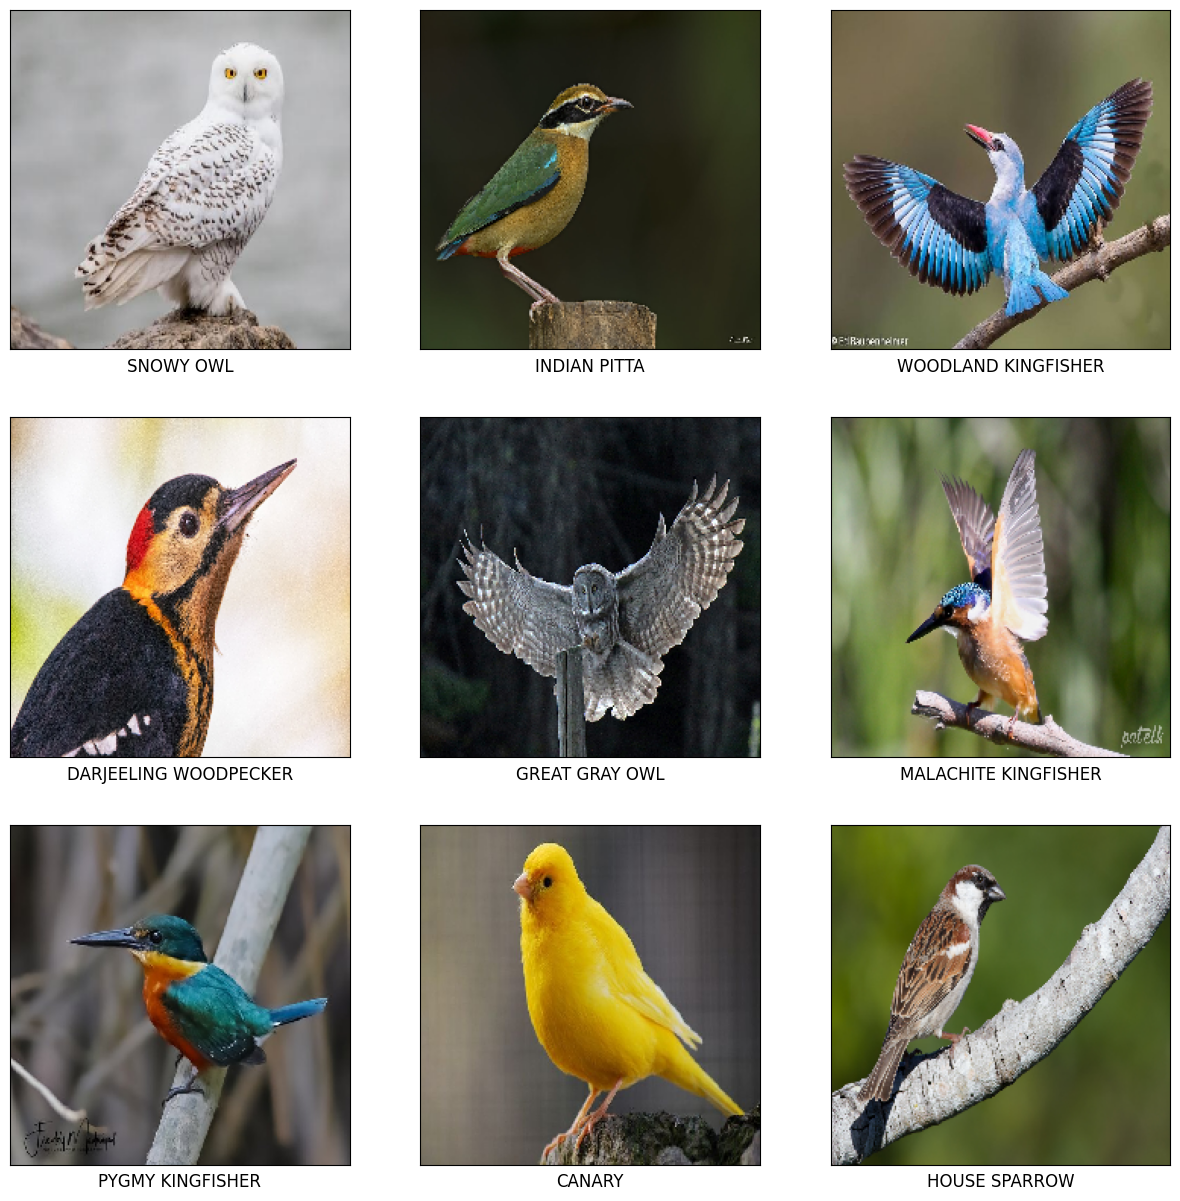

In [66]:
figure, axis = plt.subplots(3, 3, figsize=(15, 15))
k=0
for i in range(3):
    if(k==9):
        break
    for j in range(3):
        rand1 = randint(0,81)
        rand2 = randint(0,31)
        
        custom_test_image = custom_test_images[0][0][k] / 2 + 0.5
        axis[i,j].imshow(custom_test_image)
        
        pred = np.argmax(model.predict(custom_test_images[0][0]),axis=1)
        axis[i,j].set_title(CLASS_NAMES[pred[k]], y=-0.09)
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        k+=1